In [12]:
%matplotlib inline

In [2]:

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal
import pickle

import os
import pdb
from loren_frank_data_processing import (make_epochs_dataframe,
                                         make_neuron_dataframe)
from src.parameters import (ANIMALS, MIN_N_NEURONS, _BRAIN_AREAS)

from scripts.run_by_epoch import clusterless_thetasweeps
from tqdm.auto import tqdm

from scipy.stats import spearmanr, pearsonr
from scipy.signal import hilbert

In [3]:
def get_steps(Replay_traj, timeb=1):
    '''
    Get the levy exponent for replay trajectory
    Input 
        (dictionary): Replay_traj
        (int): time bin
    Output:
        (numpy array): all_steps for all ripple events
    
    '''
    #initialze an empty numpy array
    all_steps = []

    keys = Replay_traj.keys()
    for key in keys:
        #get the replay trajectory for each ripple events
        ripple_traj = Replay_traj[key]
        traj_step = np.abs(np.diff(ripple_traj[::timeb]))
        #concatenate the steps for all ripple events
        all_steps = np.concatenate((all_steps, traj_step))
    
    return all_steps

In [4]:
#log-log plot of the average step size against time bins
def get_diffusion_exponent(Replay_traj, plot=False): 
    
    #return plt
    all_timebins = np.arange(1,20,1)
    all_avg_steps = []
    for timeb in all_timebins:
        all_steps = get_steps(Replay_traj, timeb)
        #get the average step size for each time bin
        avg_step = np.mean(all_steps)
        all_avg_steps.append(avg_step)
    #get the slope of the log-log plot
    slope, intercept = np.polyfit(np.log(all_timebins), np.log(all_avg_steps), 1)
    
    #print('The slope of the log-log plot is %.2f'%slope)
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(3,3))
        #plot the log-log plot and add the slope as a lagend
        ax.plot(all_timebins, all_avg_steps, 'o', color='black')
        ax.plot(all_timebins, np.exp(intercept)*all_timebins**slope, 'r-', label='slope = %.2f'%slope)  
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Time bins')
        ax.set_ylabel('Average step size')
        ax.legend()
        #set both ticks to [0,10]
        ax.set_xticks([1,10])
        ax.set_yticks([1,10])
        return fig, ax, slope
    else:
        return slope
       

In [5]:
def bandpassfilter(data, lowcut=5, highcut=11, fs=500):
    """
    band pass filter of the signal
    Created by Zilong, 30/08/2021
    """
    lowcut = 5
    highcut = 11
    order = 5
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype="band")
    filtereddata = signal.filtfilt(b, a, data)

    return filtereddata

In [6]:
def get_zero_phase(filtered_lfp):
    """
    get the zero phase of the filtered lfp using hilbert transform
    """
    filtered_lfp = filtered_lfp.values.squeeze()
    analytic_signal = hilbert(filtered_lfp)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    # wrap the instantaneous_phase to -pi and pi
    instantaneous_phase = np.mod(instantaneous_phase + np.pi, 2 * np.pi) - np.pi
    # find phase of 0 and mark all of them as a red point on the plot
    zero_phase = np.where(
        np.logical_and(instantaneous_phase > -3.15, instantaneous_phase < -3.0)
    )[0]

    # if successive zero phase is less than 10, only keep the first one
    splits = np.split(zero_phase, np.where(np.diff(zero_phase) > 10)[0] + 1)
    zero_phase_index = np.array([split[0] for split in splits])

    return zero_phase_index

In [7]:
def get_sweep_amp_each_theta_cycle(lfp0_in_running, sweeps_dist_in_running):
    """
    get the amplitude of each sweep in each theta cycle
    Input:
        lfp0_in_running: the filtered lfp in running
        sweeps_dist_in_running: the mental distance of each sweep in running
    """
    # get the zero phase index
    zero_phase_index = get_zero_phase(lfp0_in_running)
    
    #if first element in zero_phase_index is 0, remove it
    if zero_phase_index[0] == 0:
        zero_phase_index = zero_phase_index[1:]

    # split the sweeps_dist_in_running according to the zero phase index
    # and extract the largest sweep_dist in each theta cycle
    splits = np.split(sweeps_dist_in_running, zero_phase_index)

    sweep_amp_each_theta_cycle = np.array([np.max(split) for split in splits])

    #print(sweep_amp_each_theta_cycle)
    
    return np.mean(sweep_amp_each_theta_cycle)

In [8]:
epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)

neuron_info = neuron_info.loc[
(neuron_info.type == 'principal') &
(neuron_info.numspikes > 100) &
neuron_info.area.isin(_BRAIN_AREAS)]

n_neurons = (neuron_info
                .groupby(['animal', 'day', 'epoch'])
                .neuron_id
                .agg(len)
                .rename('n_neurons')
                .to_frame())

epoch_info = epoch_info.join(n_neurons)
is_w_track = (epoch_info.environment
                .isin(['TrackA', 'TrackB', 'WTrackA', 'WTrackB']))

## Analysis for animal bon

In [ ]:

is_animal = epoch_info.index.isin(['bon'], level='animal')

valid_epochs = (is_w_track &
                (epoch_info.n_neurons > MIN_N_NEURONS) &
                is_animal
                )

DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

sweep_len1 = []
replay_ratio1 = []
exponent1 = []
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
    
    #1, LOAD THETA SWEEPS RESULTS
    
    #load the classifier results
    cv_classifier_clusterless_results = xr.open_dataset(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc'))
    #load the data with pickle
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_speed_info.pkl'), 'rb') as f:
        speed = pickle.load(f)
        speed =speed.values
    
    is_running = speed > 10
        
    #load lfp
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_data.pkl'), 'rb') as f:
        data = pickle.load(f)
        
    lfp = (
        data["lfps"]
        .reset_index(drop=True)
        .set_index(data["lfps"].index / np.timedelta64(1, "s"))
    )
    
    # add band passs filter to lfp.iloc[:,0], using band between 5-11Hz
    lfp0 = bandpassfilter(lfp.iloc[:, 0], lowcut=5, highcut=11, fs=500)
    # group the lfp0 into dataframe with time index
    lfp0 = pd.DataFrame(lfp0, index=lfp.index)
    
    lfp0_in_running = lfp0[is_running]

    sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

    mean_sweep_amp = get_sweep_amp_each_theta_cycle(lfp0_in_running, sweeps_dist_in_running)
    print(f'Average sweep amplitude in running: {mean_sweep_amp}')
    
    sweep_len1.append(mean_sweep_amp)
    
    #remove those values more than 30 in sweeps_dist_in_running
    #sweeps_dist_in_running = sweeps_dist_in_running.where(sweeps_dist_in_running<30)
    
    #find all the local peaks in sweeps_dist_in_running and average all the peaks 

        
    # #print the average sweep length
    # print(f'Average sweep length: {np.mean(sweeps_dist_in_running)}')
    # sweep_len1.append(np.mean(sweeps_dist_in_running).values)
    
    #2, LOAD REPLAY RESULTS
    #load the dictionary from the 'ReplayTrajectories' folder under PROCESSED_DATA_DIR using pickle
    with open(os.path.join(DATA_DIR, 'ReplayTrajectories', f'{animal}_{day:02d}_{epoch:02d}_traj.pkl'), 'rb') as f:
        Replay_traj = pickle.load(f)
        
    fig, ax, slope = get_exponent(Replay_traj, plot=True)
    exponent1.append(slope)
    #show the plot
    plt.show()
    
    steps = get_steps(Replay_traj, timeb=1)
    
    #Count the ratio of steps that are out of three standard deviations
    #get the mean and standard deviation of the steps
    mean = np.mean(steps)
    std = np.std(steps)
    #get the number of steps that are out of three standard deviations
    n_outlier = np.sum(np.abs(steps-mean)>2*std)
    #get the ratio and print mean and standard deviation as well
    ratio = n_outlier/len(steps)
    print(f'Ratio of steps that are out of two standard deviations: {ratio}')
    
    replay_ratio1.append(ratio)
        
        

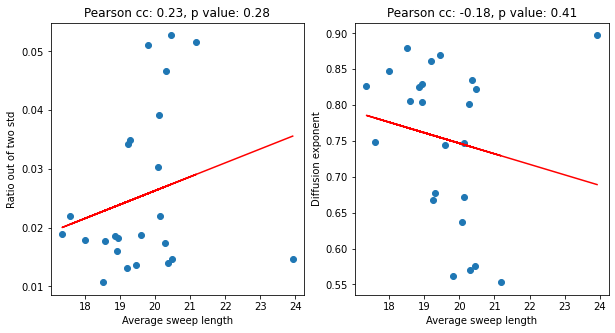

In [128]:
#plot sweep_len against replay_ratio, and against exponent1
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(np.array(sweep_len1), np.array(replay_ratio1))
plt.xlabel('Average sweep length')
plt.ylabel('Ratio out of two std')
#add linear fit line to the plot using numpy.polyfit
slope, intercept = np.polyfit(np.array(sweep_len1), np.array(replay_ratio1), 1)
plt.plot(np.array(sweep_len1), np.array(sweep_len1)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len1), np.array(replay_ratio1))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
    
plt.subplot(1,2,2)
plt.scatter(np.array(sweep_len1), np.array(exponent1))
plt.xlabel('Average sweep length')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(sweep_len1), np.array(exponent1), 1)
plt.plot(np.array(sweep_len1), np.array(sweep_len1)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len1), np.array(exponent1))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

plt.show()
    

In [ ]:
is_animal = epoch_info.index.isin(['bon'], level='animal')

valid_epochs = (is_w_track &
                (epoch_info.n_neurons > MIN_N_NEURONS) &
                is_animal
                )

DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

sweep_len0 = []
replay_ratio0 = []
exponent0 = []
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
    
    #1, LOAD THETA SWEEPS RESULTS
    
    #load the classifier results
    cv_classifier_clusterless_results = xr.open_dataset(os.path.join(DATA_DIR, 'ThetaSweepTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc'))
    #load the data with pickle
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_speed_info.pkl'), 'rb') as f:
        speed = pickle.load(f)
        speed = speed.values
        
    #get the average sweep length
    #extract speed from data and threshold it with 10 cm/s
    is_running = speed > 4

    sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

    #print the average sweep length
    print(f'Average sweep length: {np.mean(sweeps_dist_in_running)}')
    sweep_len0.append(np.mean(sweeps_dist_in_running).values)
    
    #2, LOAD REPLAY RESULTS
    #load the dictionary from the 'ReplayTrajectories' folder under PROCESSED_DATA_DIR using pickle
    with open(os.path.join(DATA_DIR, 'ReplayTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_traj.pkl'), 'rb') as f:
        Replay_traj = pickle.load(f)
        
    #fig, ax, slope = get_exponent(Replay_traj, plot=True)
    slope = get_exponent(Replay_traj, plot=False)
    print(f'The slope of the log-log plot is %.2f'%slope)
    exponent0.append(slope)
    #plt.show()
        
    steps = get_steps(Replay_traj, timeb=1)
    
    #Count the ratio of steps that are out of three standard deviations
    #get the mean and standard deviation of the steps
    mean = np.mean(steps)
    std = np.std(steps)
    #get the number of steps that are out of three standard deviations
    n_outlier = np.sum(np.abs(steps-mean)>2*std)
    #get the ratio and print mean and standard deviation as well
    ratio = n_outlier/len(steps)
    print(f'Ratio of steps that are out of two standard deviations: {ratio}')
    
    replay_ratio0.append(ratio)
        
        

In [ ]:
#plot sweep_len against replay_ratio, and against exponent1
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(np.array(sweep_len0), np.array(replay_ratio0))
plt.xlabel('Average sweep length')
plt.ylabel('Ratio out of two std')
#add linear fit line to the plot using numpy.polyfit
slope, intercept = np.polyfit(np.array(sweep_len0), np.array(replay_ratio0), 1)
plt.plot(np.array(sweep_len0), np.array(sweep_len0)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len0), np.array(replay_ratio0))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
    
plt.subplot(1,2,2)
plt.scatter(np.array(sweep_len0), np.array(exponent0))
plt.xlabel('Average sweep length')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(sweep_len0), np.array(exponent0), 1)
plt.plot(np.array(sweep_len0), np.array(sweep_len0)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len0), np.array(exponent0))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

plt.show()

## Analysis for animal con

In [ ]:
is_animal = epoch_info.index.isin(['con'], level='animal')

valid_epochs = (is_w_track &
                (epoch_info.n_neurons > MIN_N_NEURONS) &
                is_animal
                )

DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

DATA_DIR = '/media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis'

sweep_len1 = []
replay_ratio1 = []
exponent1 = []
ave_speed1 = []
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
    
    #1, LOAD THETA SWEEPS RESULTS
    
    #load the classifier results
    cv_classifier_clusterless_results = xr.open_dataset(os.path.join(DATA_DIR, 'ThetaSweepTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc'))
    #load the data with pickle
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_speed_info.pkl'), 'rb') as f:
        speed = pickle.load(f)
        speed = speed.values
        
    #get the average sweep length
    #extract speed from data and threshold it with 10 cm/s
    is_running = speed > 4

    sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

    #print the average sweep length
    print(f'Average sweep length: {np.mean(sweeps_dist_in_running)}')
    
    if np.mean(sweeps_dist_in_running).values > 40:
        continue
    
    #get mean speed with speed < 4
    mean_speed = np.mean(speed[speed<4])
    ave_speed1.append(mean_speed)
    
    sweep_len1.append(np.mean(sweeps_dist_in_running).values)
    
    #2, LOAD REPLAY RESULTS
    #load the dictionary from the 'ReplayTrajectories' folder under PROCESSED_DATA_DIR using pickle
    with open(os.path.join(DATA_DIR, 'ReplayTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_traj.pkl'), 'rb') as f:
        Replay_traj = pickle.load(f)
        
    #fig, ax, slope = get_exponent(Replay_traj, plot=True)
    slope = get_exponent(Replay_traj, plot=False)
    print(f'The slope of the log-log plot is %.2f'%slope)
    exponent1.append(slope)
    #plt.show()
        
    steps = get_steps(Replay_traj, timeb=1)
    
    #Count the ratio of steps that are out of three standard deviations
    #get the mean and standard deviation of the steps
    mean = np.mean(steps)
    std = np.std(steps)
    #get the number of steps that are out of three standard deviations
    n_outlier = np.sum(np.abs(steps-mean)>2*std)
    #get the ratio and print mean and standard deviation as well
    ratio = n_outlier/len(steps)
    print(f'Ratio of steps that are out of two standard deviations: {ratio}')
    
    replay_ratio1.append(ratio)
        
        

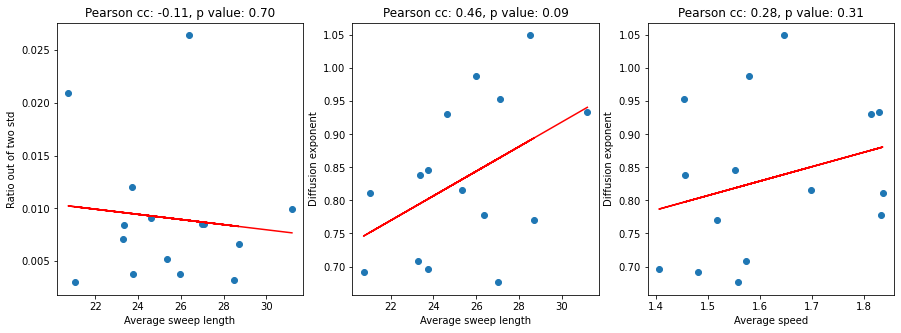

In [20]:
#plot sweep_len against replay_ratio, and against exponent1
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(np.array(sweep_len1), np.array(replay_ratio1))
plt.xlabel('Average sweep length')
plt.ylabel('Ratio out of two std')
#add linear fit line to the plot using numpy.polyfit
slope, intercept = np.polyfit(np.array(sweep_len1), np.array(replay_ratio1), 1)
plt.plot(np.array(sweep_len1), np.array(sweep_len1)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len1), np.array(replay_ratio1))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
    
plt.subplot(1,3,2)
plt.scatter(np.array(sweep_len1), np.array(exponent1))
plt.xlabel('Average sweep length')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(sweep_len1), np.array(exponent1), 1)
plt.plot(np.array(sweep_len1), np.array(sweep_len1)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len1), np.array(exponent1))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

#plot exponent against average speed
plt.subplot(1,3,3)
plt.scatter(np.array(ave_speed1), np.array(exponent1))
plt.xlabel('Average speed')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(ave_speed1), np.array(exponent1), 1)
plt.plot(np.array(ave_speed1), np.array(ave_speed1)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(ave_speed1), np.array(exponent1))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

plt.show()

## Get theta sweep and replay results for one animal

In [9]:
def get_sweep_and_replay_results(epoch_key, datadir, sweep_speed_threshold=4):
    '''
    Get the average sweep length and replay exponent for one epoch
    '''
    animal, day, epoch = epoch_key
    
    #1, LOAD THETA SWEEPS RESULTS
    #load the classifier results
    cv_classifier_clusterless_results = xr.open_dataset(os.path.join(datadir, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc'))
    #load the data with pickle
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_speed_info.pkl'), 'rb') as f:
        speed = pickle.load(f)
        speed = speed.values
    
    #get the average sweep length
    #extract speed from data and threshold it with 10 cm/s
    is_running = speed > sweep_speed_threshold

    sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]
    
    #get mean speed with speed < 4 (mean speed udring immobile state)
    mean_immobile_speed = np.mean(speed[speed<4])
    
    mean_sweep_dist = np.mean(sweeps_dist_in_running).values
    
    #2, LOAD REPLAY RESULTS
    #load the dictionary from the 'ReplayTrajectories' folder under PROCESSED_DATA_DIR using pickle
    with open(os.path.join(datadir, 'ReplayTrajectories', f'{animal}_{day:02d}_{epoch:02d}_traj.pkl'), 'rb') as f:
        Replay_traj = pickle.load(f)
        
    #fig, ax, slope = get_exponent(Replay_traj, plot=True)
    replay_exponent = get_diffusion_exponent(Replay_traj, plot=False)
        
    return mean_immobile_speed, mean_sweep_dist, replay_exponent
    

In [10]:
is_animal = epoch_info.index.isin(['cha'], level='animal')

valid_epochs = (is_w_track &
                (epoch_info.n_neurons > MIN_N_NEURONS) &
                is_animal
                )

DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

sweep_len = []
exponent = []
ave_speed = []
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
    
    #get the average sweep length and replay exponent
    mean_immobile_speed, mean_sweep_dist, replay_exponent = get_sweep_and_replay_results(epoch_key, DATA_DIR)

    #print the average sweep length and replay exponent in one line, keep three decimal places
    print(f'Average sweep length: {mean_sweep_dist:.3f}, Diffusion exponent: {replay_exponent:.3f}')

    ave_speed.append(mean_immobile_speed)
    sweep_len.append(mean_sweep_dist)
    exponent.append(replay_exponent)

        

epochs:   0%|          | 0/4 [00:00<?, ?it/s]

Animal: cha, Day: 4, Epoch: 2


epochs:  25%|██▌       | 1/4 [00:04<00:13,  4.52s/it]

Average sweep length: 50.093, Diffusion exponent: 0.727
Animal: cha, Day: 4, Epoch: 4


epochs:  50%|█████     | 2/4 [00:13<00:14,  7.18s/it]

Average sweep length: 46.601, Diffusion exponent: 0.583
Animal: cha, Day: 8, Epoch: 2


epochs:  75%|███████▌  | 3/4 [00:22<00:08,  8.13s/it]

Average sweep length: 50.168, Diffusion exponent: 0.572
Animal: cha, Day: 8, Epoch: 4


epochs: 100%|██████████| 4/4 [00:32<00:00,  8.19s/it]

Average sweep length: 40.948, Diffusion exponent: 0.668


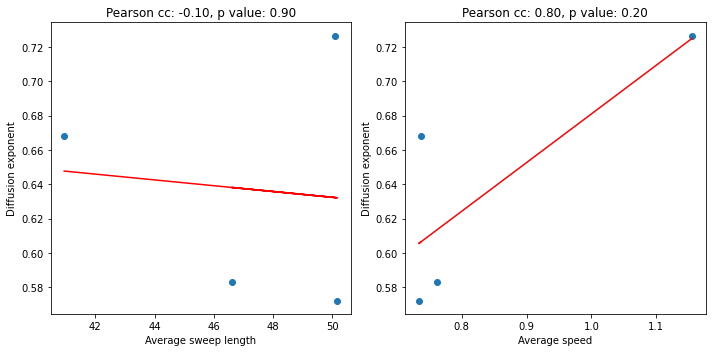

In [13]:
#plot sweep_len against replay_ratio, and against exponent1
plt.figure(figsize=(10,5))
  
plt.subplot(1,2,1)
plt.scatter(np.array(sweep_len), np.array(exponent))
plt.xlabel('Average sweep length')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(sweep_len), np.array(exponent), 1)
plt.plot(np.array(sweep_len), np.array(sweep_len)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len), np.array(exponent))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

#plot exponent against average speed
plt.subplot(1,2,2)
plt.scatter(np.array(ave_speed), np.array(exponent))
plt.xlabel('Average speed')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(ave_speed), np.array(exponent), 1)
plt.plot(np.array(ave_speed), np.array(ave_speed)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(ave_speed), np.array(exponent))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

plt.tight_layout()
plt.show()

## Analysis for all animals

In [20]:
animal_names = ['bon', 'fra', 'gov', 'dud', 'con', 'dav', 'Cor', 'egy', 'cha']

all_sweep_len_peranimal = {}; all_sweep_len_perday = {}
all_exponent_peranimal = {}; all_exponent_perday = {}
all_ave_speed_peranimal = {}; all_ave_speed_perday = {}
DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

for name in animal_names:
    
    is_animal = epoch_info.index.isin([name], level='animal')

    valid_epochs = (is_w_track &
                    (epoch_info.n_neurons > MIN_N_NEURONS) &
                    is_animal
                    )

    sweep_len = [];
    exponent = []
    ave_speed = []
    for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
        animal, day, epoch = epoch_key
        #skip 'egy', 10, 2 since no mental_distance_from_actual_position is saved (double check later)
        if (animal, day, epoch) == ('egy', 10, 2):
            continue

        print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
        
        #get the average sweep length and replay exponent
        mean_immobile_speed, mean_sweep_dist, replay_exponent = get_sweep_and_replay_results(epoch_key, DATA_DIR, sweep_speed_threshold=4)
        
        #print the average sweep length and replay exponent in one line, keep three decimal places
        print(f'Average sweep length: {mean_sweep_dist:.3f}, Diffusion exponent: {replay_exponent:.3f}')
        
        #attach (without overwriting) mean_immobile_speed, mean_sweep_dist, replay_exponent to 
        #all_sweep_len_perday, all_exponent_perday, all_ave_speed_perday with the key of (animal, day)
        all_sweep_len_perday.setdefault((animal, day), []).append(mean_sweep_dist)
        all_exponent_perday.setdefault((animal, day), []).append(replay_exponent)
        all_ave_speed_perday.setdefault((animal, day), []).append(mean_immobile_speed)
        
        ave_speed.append(mean_immobile_speed)
        sweep_len.append(mean_sweep_dist)
        exponent.append(replay_exponent)
        
    all_ave_speed_peranimal[name] = ave_speed   
    all_sweep_len_peranimal[name] = sweep_len
    all_exponent_peranimal[name] = exponent


epochs:  68%|██████▊   | 13/19 [00:00<00:00, 2125.69it/s]

Animal: egy, Day: 10, Epoch: 2


AttributeError: 'Dataset' object has no attribute 'mental_distance_from_actual_position'

In [33]:
results_ = xr.open_dataset(os.path.join('/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ThetaSweepTrajectories', f'bon_03_02_cv_classifier_clusterless_results.nc'))
results_.mental_distance_from_actual_position

<xarray.DataArray 'mental_distance_from_actual_position' (time: 465497)>
[465497 values with dtype=float64]
Coordinates:
  * time     (time) float64 3.729e+03 3.729e+03 3.729e+03 ... 4.66e+03 4.66e+03

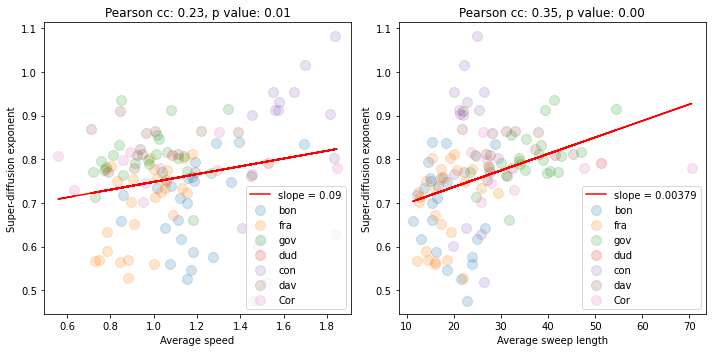

In [17]:
#plot ave_speed against replay_exponent for each animal, each with different color in subplot 1
#plot sweep_len against replay_exponent for each animal, each with different color in subplot 2
#using all_ave_speed_peranimal, all_sweep_len_peranimal, all_exponent_peranimal here

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for name in animal_names:
    plt.scatter(np.array(all_ave_speed_peranimal[name]), np.array(all_exponent_peranimal[name]), label=name, s=100, alpha=0.2)
all_exp_np = np.concatenate(list(all_exponent_peranimal.values()))
all_speed_np = np.concatenate(list(all_ave_speed_peranimal.values()))
#add linear fit line to all_exp_np vs all_speed_np
slope, intercept = np.polyfit(all_speed_np, all_exp_np, 1)
plt.plot(all_speed_np, all_speed_np*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(all_speed_np, all_exp_np)
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
plt.xlabel('Average speed')
plt.ylabel('Super-diffusion exponent')
plt.legend()

plt.subplot(1,2,2)
for name in animal_names:
    plt.scatter(np.array(all_sweep_len_peranimal[name]), np.array(all_exponent_peranimal[name]), label=name, s=100, alpha=0.2)
all_exp_np = np.concatenate(list(all_exponent_peranimal.values()))
all_sweep_len_np = np.concatenate(list(all_sweep_len_peranimal.values()))
#add linear fit line to all_exp_np vs all_speed_np
slope, intercept = np.polyfit(all_sweep_len_np, all_exp_np, 1)
plt.plot(all_sweep_len_np, all_sweep_len_np*slope+intercept, 'r-', label='slope = %.5f'%slope)
#pearson test
corr, p = pearsonr(all_sweep_len_np, all_exp_np)
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
plt.xlabel('Average sweep length')
plt.ylabel('Super-diffusion exponent')
plt.legend()

plt.tight_layout()



In [1]:
#plot ave_speed against replay_exponent for each animal, each with different color in subplot 1
#plot sweep_len against replay_exponent for each animal, each with different color in subplot 2
#using all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday here

#group all the keys in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday by animal name
all_ave_speed_peranimal = {}

#first avearge all the values under each key in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday
all_ave_speed_perday_ave = {}
all_sweep_len_perday_ave = {}
all_exponent_perday_ave = {}
for key in all_ave_speed_perday.keys():
    all_ave_speed_perday_ave[key] = np.mean(all_ave_speed_perday[key])
    all_sweep_len_perday_ave[key] = np.mean(all_sweep_len_perday[key])
    all_exponent_perday_ave[key] = np.mean(all_exponent_perday[key])
    
#group all the keys in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday by animal name
all_ave_speed_perday_concat = {}
all_sweep_len_perday_concat = {}
all_exponent_perday_concat = {}
for key in all_ave_speed_perday.keys():
    all_ave_speed_perday_concat.setdefault(key[0], []).append(all_ave_speed_perday_ave[key])
    all_sweep_len_perday_concat.setdefault(key[0], []).append(all_sweep_len_perday_ave[key])
    all_exponent_perday_concat.setdefault(key[0], []).append(all_exponent_perday_ave[key])
   
#select colors equals to number of animals from a colormap
#put them in a dictionary with animal names as keys
colors = plt.cm.get_cmap('tab10', len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)
 
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
#plot all_exponent_perday_concat against all_ave_speed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_ave_speed_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.5, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_speed_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
speed_np = np.concatenate(list(all_ave_speed_perday_concat.values()))
slope, intercept = np.polyfit(speed_np, exp_np, 1)
plt.plot(speed_np, speed_np*slope+intercept, 'r-', label='slope = %.2f'%slope)

#pearson test
corr, p = pearsonr(speed_np, exp_np)
plt.title('Pearson cc: %.2f, p value: %.3f'%(corr, p))
plt.xlabel('Average speed')
plt.ylabel('Super-diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.subplot(1,2,2)
#plot all_exponent_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_len_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.5, color=color_dict[name])   
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_len_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
plt.plot(sweep_len_np, sweep_len_np*slope+intercept, 'r-', label='slope = %.5f'%slope)
#pearson test
corr, p = pearsonr(sweep_len_np, exp_np)
plt.title('Pearson cc: %.2f, p value: %.3f'%(corr, p))
plt.xlabel('Average sweep length')
plt.ylabel('Super-diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()




NameError: name 'all_ave_speed_perday' is not defined